# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Quiet TF + stick to CPU (Codio typically has no GPU)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import random, datetime, json, sys, time
import matplotlib.pyplot as plt

import tensorflow as tf
try:
    tf.get_logger().setLevel('ERROR')
    tf.config.set_visible_devices([], "GPU")  # CPU-only
except Exception:
    pass

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, PReLU, Input
from tensorflow.keras.optimizers import Adam  

from TreasureMaze import TreasureMaze
from GameExperience import GameExperience

%matplotlib inline


2025-10-05 16:41:19.843332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759682481.829862   22775 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759682482.142714   22775 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759682484.772677   22775 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759682484.772718   22775 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759682484.772721   22775 computation_placer.cc:177] computation placer alr

The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, ncols, 1))  # use ncols for x
    ax.set_yticks(np.arange(0.5, nrows, 1))  # use nrows for y
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    canvas = np.copy(qmaze.maze)
    for row, col in qmaze.visited:
        canvas[row, col] = 0.6          # visited
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3 # pirate
    canvas[nrows-1, ncols-1] = 0.9       # treasure

    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img


The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


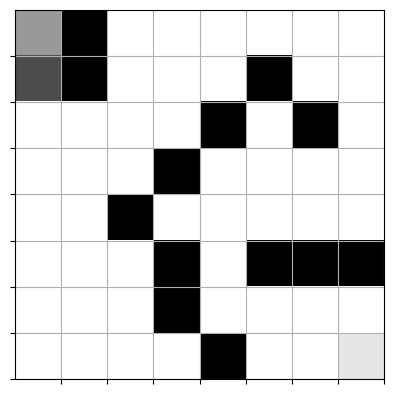

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [7]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [8]:
def completion_check(model, qmaze, step_cap=None):
    """Return True if the model can win from every free cell."""
    for cell in qmaze.free_cells:
        # must have at least one legal action from this cell
        if not qmaze.valid_actions(cell):
            return False
        # use the robust play_game we added (with optional cap)
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [9]:
def build_model(maze):
    state_size = int(np.prod(maze.shape))  # e.g., 64 for 8x8
    num_actions = 4  # LEFT, UP, RIGHT, DOWN

    model = Sequential([
        Input(shape=(state_size,)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_actions, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model


# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [10]:
def qtrain(model, maze, **opt):
    import datetime, random
    import numpy as np

    global epsilon  # exploration rate

    # options (sane defaults; override via **opt)
    n_epoch        = opt.get('n_epoch', 15000)
    max_memory     = opt.get('max_memory', 1000)
    data_size      = opt.get('data_size', 50)
    batch_size     = opt.get('batch_size', 50)
    min_epsilon    = opt.get('min_epsilon', 0.05)
    epsilon_decay  = opt.get('epsilon_decay', 0.997)

    start_time = datetime.datetime.now()
    qmaze = TreasureMaze(maze)
    experience = GameExperience(model, max_memory=max_memory)

    win_history = []
    hsize = qmaze.maze.size // 2
    win_rate = 0.0

    for epoch in range(n_epoch):
        game_over  = False
        n_episodes = 0
        loss       = 0.0

        # start from a random free cell
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        envstate = qmaze.observe()

        while not game_over:
            prev_envstate = envstate

            # valid actions (support both signatures)
            try:
                valid_actions = qmaze.valid_actions(qmaze.state[:2])
            except TypeError:
                valid_actions = qmaze.valid_actions()
            if not valid_actions:
                break

            # epsilon-greedy
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                q = model.predict(prev_envstate, verbose=0)
                action = int(np.argmax(q))

            # environment step
            envstate, reward, game_status = qmaze.act(action)

            # terminal?
            if game_status in ('win', 'lose'):
                win_history.append(1 if game_status == 'win' else 0)
                game_over = True

            # remember & train (one mini-update)
            episode = [prev_envstate, action, reward, envstate, game_status]
            experience.remember(episode)

            inputs, targets = experience.get_data(data_size=data_size)
            hist = model.fit(inputs, targets, epochs=1, batch_size=batch_size, verbose=0)
            loss = float(hist.history['loss'][0])

            n_episodes += 1

        # smooth epsilon decay each epoch
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # rolling win rate
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / float(hsize)
        else:
            win_rate = sum(win_history) / float(max(1, len(win_history)))

        # progress
        dt = datetime.datetime.now() - start_time
        t  = format_time(dt.total_seconds())
        print("Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
              .format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))

        # early stop
        if len(win_history) >= hsize and sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100% win rate at epoch: %d" % epoch)
            break

    # total time
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s"
          % (epoch, max_memory, data_size, format_time(seconds)))
    return seconds


def format_time(seconds):
    if seconds < 400:
        return "%.1f seconds" % seconds
    elif seconds < 4000:
        return "%.2f minutes" % (seconds/60.0)
    else:
        return "%.2f hours" % (seconds/3600.0)



## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

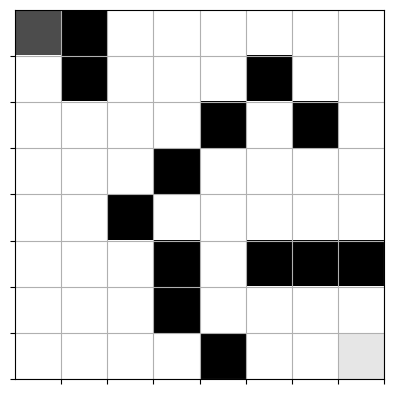

In [11]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [ ]:
epsilon = 1.0
model   = build_model(maze)

qtrain(
    model, maze,
    n_epoch=1000,                 
    max_memory=8*maze.size,
    data_size=32,
    batch_size=32,
    min_epsilon=0.05,
    epsilon_decay=0.997
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [ ]:
qmaze = TreasureMaze(maze)

print("Completion check:", completion_check(model, qmaze))

show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

In [ ]:
import random

qmaze = TreasureMaze(maze)

pirate_start = (0, 0) if (0, 0) in qmaze.free_cells else random.choice(qmaze.free_cells)

won = play_game(model, qmaze, pirate_start)
print("Start:", pirate_start, "| Win?", won)

show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work.
Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.html). Download this file as an .html file clicking on ***file*** in *Jupyter Notebook*, navigating down to ***Download as*** and clicking on ***.html***. 
Download a copy of your .html file and submit it to Brightspace.